Hidden-Shift Benchmark Program - Cirq
... execution starting at Jun 06, 2024 09:08:20 UTC
************
Executing [3] circuits with num_qubits = 2
Average Creation, Elapsed, Execution Time for the 2 qubit group = 0.0, 0.021, 0.017 secs
Average Hellinger, Normalized Fidelity for the 2 qubit group = 1.0, 1.0

************
Executing [3] circuits with num_qubits = 4
Average Creation, Elapsed, Execution Time for the 4 qubit group = 0.0, 0.008, 0.003 secs
Average Hellinger, Normalized Fidelity for the 4 qubit group = 1.0, 1.0

************
Executing [3] circuits with num_qubits = 6
Average Creation, Elapsed, Execution Time for the 6 qubit group = 0.0, 0.01, 0.004 secs
Average Hellinger, Normalized Fidelity for the 6 qubit group = 1.0, 1.0

************
Executing [3] circuits with num_qubits = 8
Average Creation, Elapsed, Execution Time for the 8 qubit group = 0.001, 0.012, 0.005 secs
Average Hellinger, Normalized Fidelity for the 8 qubit group = 1.0, 1.0

************
Executing [3] circuits w

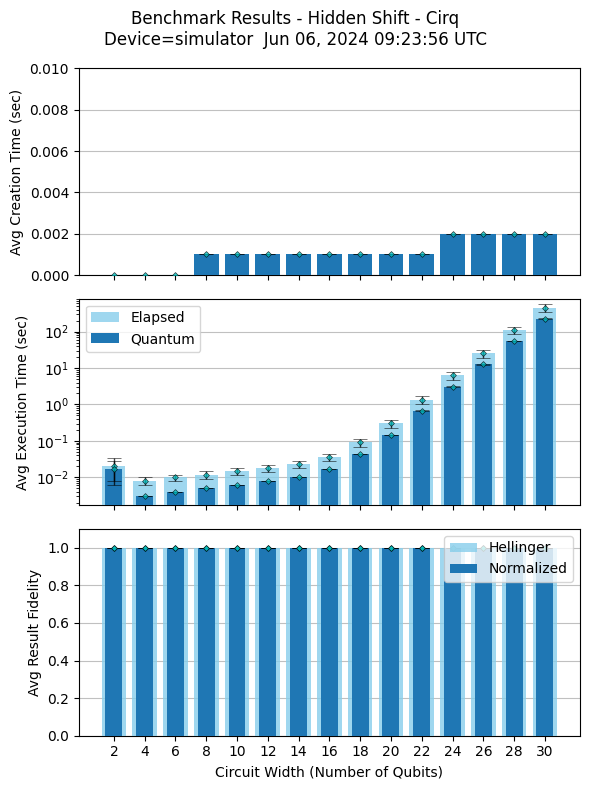

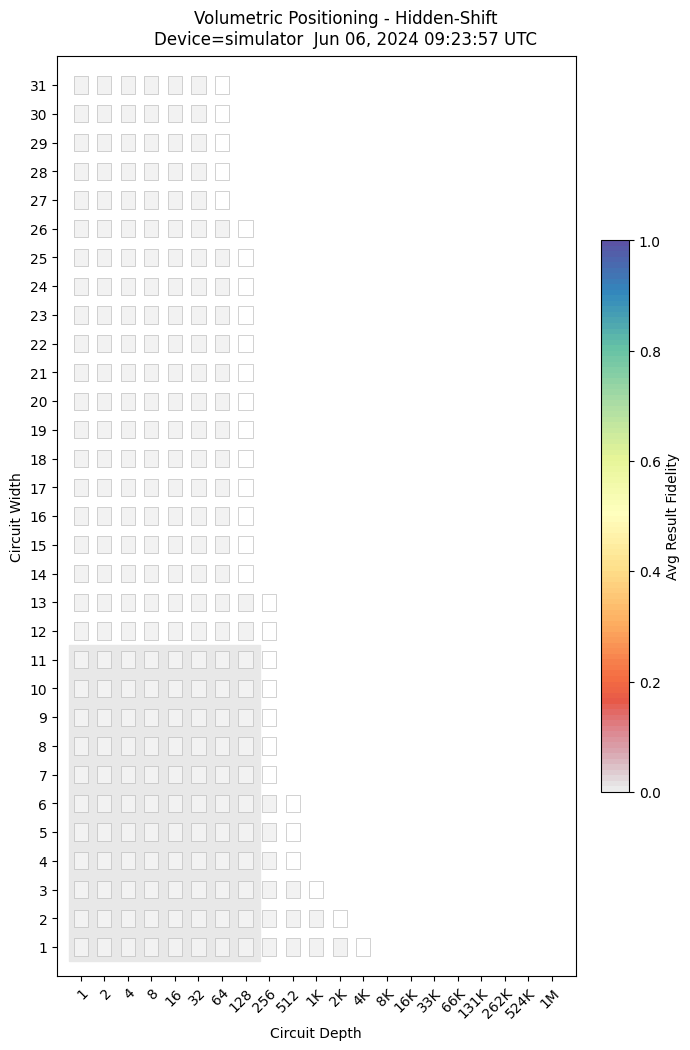

In [1]:
"""
Hidden-Shift Benchmark Program - Cirq
"""

from collections import defaultdict
import sys
import time

import cirq
import numpy as np

sys.path[1:1] = ["_common", "_common/cirq"]
sys.path[1:1] = ["../../_common", "../../_common/cirq"]
import cirq_utils as cirq_utils
import execute as ex
import metrics as metrics

np.random.seed()

verbose = False

# saved circuits for display
QC_ = None
Uf_ = None
Ug_ = None

############### Circuit Definition
def Uf_oracle(num_qubits, secret_int):
    # allocate qubits
    qr = [cirq.GridQubit(i, 0) for i in range(num_qubits)]
    qc = cirq.Circuit()

    # Perform X on each qubit that matches a bit in secret string
    s = ('{0:0'+str(num_qubits)+'b}').format(secret_int)
    for i_qubit in range(num_qubits):
        if s[num_qubits-1-i_qubit]=='1':
            qc.append(cirq.X(qr[i_qubit]))

    for i_qubit in range(0,num_qubits-1,2):
        qc.append(cirq.CZ(qr[i_qubit], qr[i_qubit+1]))

    # Perform X on each qubit that matches a bit in secret string
    s = ('{0:0'+str(num_qubits)+'b}').format(secret_int)
    for i_qubit in range(num_qubits):
        if s[num_qubits-1-i_qubit]=='1':
            qc.append(cirq.X(qr[i_qubit]))

    return cirq_utils.to_gate(num_qubits=num_qubits, circ=qc, name="Uf")

def Ug_oracle(num_qubits):
    # allocate qubits
    qr = [cirq.GridQubit(i, 0) for i in range(num_qubits)]
    qc = cirq.Circuit()

    for i_qubit in range(0, num_qubits - 1, 2):
        qc.append(cirq.CZ(qr[i_qubit], qr[i_qubit + 1]))

    return cirq_utils.to_gate(num_qubits=num_qubits, circ=qc,name="Ug")

def HiddenShift (num_qubits, secret_int):

    # allocate qubits
    qr = [cirq.GridQubit(i, 0) for i in range(num_qubits)]
    qc = cirq.Circuit()

    # Add Hadamard on all qubits
    for i_qubit in range(num_qubits):
        qc.append(cirq.H(qr[i_qubit]))

    # Generate Uf oracle
    Uf = Uf_oracle(num_qubits, secret_int)
    qc.append(Uf.on(*qr))

    # Again do Hadamard on all qubits
    for i_qubit in range(num_qubits):
        qc.append(cirq.H(qr[i_qubit]))

    # Generate Ug oracle
    Ug = Ug_oracle(num_qubits)
    qc.append(Ug.on(*qr))

    # End with Hadamard on all qubits
    for i_qubit in range(num_qubits):
        qc.append(cirq.H(qr[i_qubit]))

    # measure all qubits
    qc.append(cirq.measure(*[qr[i_qubit] for i_qubit in range(num_qubits)], key='result'))

    # save smaller circuit example for display
    global QC_, Uf_, Ug_
    if QC_ == None or num_qubits <= 6:
        if num_qubits < 9: QC_ = qc
    if Uf_ == None or num_qubits <= 6:
        if num_qubits < 9: Uf_ = Uf
    if Ug_ == None or num_qubits <= 6:
        if num_qubits < 9: Ug_ = Ug

    # return a handle on the circuit
    return qc


############### Result Data Analysis

# Analyze and print measured results
# Expected result is always the secret_int, so fidelity calc is simple
def analyze_and_print_result(qc, result, num_qubits, secret_int, num_shots):

    # get measurement array
    measurements = result.measurements['result']
    
    # create counts distribution
    counts = defaultdict(lambda: 0)
    for row in measurements:
        counts["".join([str(x) for x in reversed(row)])] += 1
    if verbose: print(f"For secret int {secret_int} measured: {counts}")
    
    # create the key that is expected to have all the measurements (for this circuit)
    key = format(secret_int, f"0{num_qubits}b")
    
    # correct distribution is measuring the key 100% of the time
    correct_dist = {key: 1.0}

    # use our polarization fidelity rescaling
    fidelity = metrics.polarization_fidelity(counts, correct_dist)
        
    return counts, fidelity


################ Benchmark Loop

# Execute program with default parameters
def run(min_qubits=2, max_qubits=30, max_circuits=3, num_shots=1000,
        backend_id='simulator', provider_backend=None):

    print("Hidden-Shift Benchmark Program - Cirq")

    # validate parameters (smallest circuit is 2 qubits)
    max_qubits = max(2, max_qubits)
    min_qubits = min(max(2, min_qubits), max_qubits)
    if min_qubits % 2 == 1: min_qubits += 1   # min_qubits must be even
    #print(f"min, max qubits = {min_qubits} {max_qubits}")
    
    # Initialize metrics module
    metrics.init_metrics()

    # Define custom result handler
    def execution_handler(qc, result, num_qubits, s_int, num_shots):

        # determine fidelity of result set
        num_qubits = int(num_qubits)
        counts, fidelity = analyze_and_print_result(qc, result, num_qubits, int(s_int), num_shots)
        metrics.store_metric(num_qubits, s_int, 'fidelity', fidelity)

    # Initialize execution module   with the result handler  
    ex.init_execution(execution_handler)
    ex.set_execution_target(backend_id, provider_backend=provider_backend)

    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for num_qubits in range(min_qubits, max_qubits + 1, 2):

        # determine number of circuits to execute for this group
        num_circuits = min(2 ** (num_qubits), max_circuits)
        
        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")
        
        # determine range of secret strings to loop over
        if 2**(num_qubits) <= max_circuits:
            s_range = list(range(num_circuits))
        else:
            s_range = np.random.choice(2**(num_qubits), num_circuits, False)
        
        # loop over limited # of secret strings for this
        for s_int in s_range:
        
            # create the circuit for given qubit size and secret string, store time metric
            ts = time.time()
            qc = HiddenShift(num_qubits, s_int)
            metrics.store_metric(num_qubits, s_int, 'create_time', time.time()-ts)
            
            # submit circuit for execution on target (simulator, cloud simulator, or hardware)
            ex.submit_circuit(qc, num_qubits, s_int, num_shots)

        # execute all circuits for this group, aggregate and report metrics when complete
        ex.execute_circuits()
        metrics.aggregate_metrics_for_group(num_qubits)
        metrics.report_metrics_for_group(num_qubits)

    # Alternatively, execute all circuits, aggregate and report metrics
    # ex.execute_circuits()
    # metrics.aggregate_metrics_for_group(num_qubits)
    # metrics.report_metrics_for_group(num_qubits)

    # # print a sample circuit
    # print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    # qr_state = [cirq.GridQubit(i, 0) for i in range(Uf_.num_qubits)] # we need to create registers to print circuits in cirq
    # print("\nQuantum Oracle 'Uf' ="); print(cirq.Circuit(cirq.decompose(Uf_.on(*qr_state))) if Uf_ != None else " ... too large!")
    # print("\nQuantum Oracle 'Ug' ="); print(cirq.Circuit(cirq.decompose(Ug_.on(*qr_state))) if Ug_ != None else " ... too large!")

    # Plot metrics for all circuit sizes
    metrics.plot_metrics("Benchmark Results - Hidden Shift - Cirq")


# if main, execute method
if __name__ == '__main__': run()
